In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import csv

## Reading

In [2]:
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 150

In [197]:
n_datasets = 4

In [23]:
raw = pd.read_csv("1-data/1.csv", delimiter=",")
raw

,Time (s),Signal strength,Ax (m/s²),Ay (m/s²),Az (m/s²),Bx (µT),By (µT),Bz (µT),ωx (rad/s),ωy (rad/s),ωz (rad/s),Voltage (mV)
0,0.010000,42,-0.536807,-9.789081,0.247404,-0.089361,41.456741,-10.609064,-0.053607,0.069939,-0.179080,-0.011513
1,0.020000,46,-0.502178,-9.831975,0.396330,-0.016365,41.734440,-10.315061,-0.055717,0.061498,-0.166419,-0.013082
2,0.030000,42,-0.414194,-9.831584,0.449293,-0.131439,41.793251,-10.725967,-0.049278,0.055277,-0.147882,-0.011513
3,0.040000,41,-0.351437,-9.789007,0.491708,-0.129899,41.854012,-11.195004,-0.044823,0.041624,-0.126718,-0.012036
4,0.050000,41,-0.366952,-9.793441,0.452033,0.347586,42.328392,-10.630507,-0.038212,0.027244,-0.109024,-0.012036
...,...,...,...,...,...,...,...,...,...,...,...,...
6246,62.470001,45,0.455228,-10.090271,-0.190746,-13.627788,41.862675,8.521285,0.031297,5.724003,0.051540,-0.008372
6247,62.480000,45,0.454857,-10.090126,-0.166850,-14.158513,42.189053,8.203773,0.020145,5.651236,0.031775,-0.007850
6248,62.490002,46,0.450016,-10.075915,-0.171323,-14.482439,42.239689,8.099657,0.010564,5.579524,0.014660,-0.006803
6249,62.500000,45,0.430548,-10.056778,-0.185704,-14.658834,41.971630,7.690300,0.004429,5.508178,-0.003315,-0.006803


In [79]:

t_raw = raw["Time (s)"].to_numpy()
w_raw = raw["ωy (rad/s)"].to_numpy()
v_raw = raw["Voltage (mV)"].to_numpy()*1e3


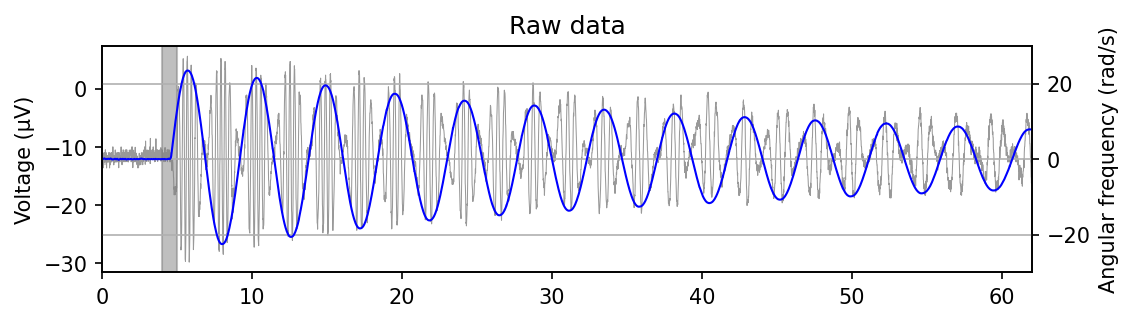

In [88]:

plt.rcParams['figure.figsize'] = [8, 2]

fig, ax1 = plt.subplots() 
ax2 = ax1.twinx()

ax1.plot(t_raw, v_raw, lw=0.5, color="gray", alpha=0.8)
ax1.set_ylabel("Voltage (µV)")

ax2.plot(t_raw, w_raw, lw=1, color="blue")

ax2.grid()
ax2.set_ylabel("Angular frequency (rad/s)")
ax2.set_xlabel("Time (s)")
ax2.set_ylim(-30,30)
ax2.set_xlim(0,62)

ax1.axvspan(4,5, color="gray", alpha=0.5, lw=1)

plt.margins(0)

plt.title("Raw data")
plt.show()

In [113]:
select = t_raw > 5
antiselect = t_raw < 4

t = t_raw[select] - 5
w = w_raw[select] - np.average(w_raw[antiselect])
v = v_raw[select] - np.average(v_raw[antiselect])


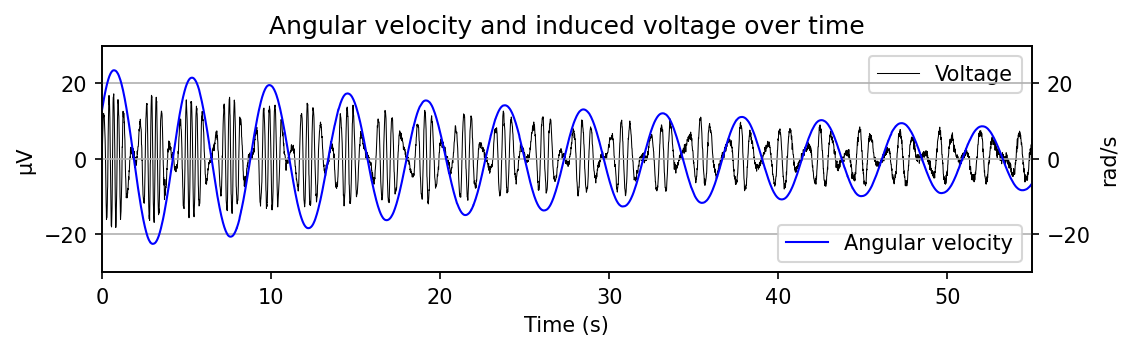

In [342]:
plt.rcParams['figure.figsize'] = [8, 2]

fig, ax1 = plt.subplots() 
ax2 = ax1.twinx()

ax1.plot(t, v, lw=0.5, color="black", label="Voltage")
ax1.set_ylabel("µV")
ax1.set_ylim(-30,30)
ax1.legend(loc="upper right")


ax2.plot(t, w, lw=1, color="blue", label="Angular velocity")

ax2.grid()
ax2.set_ylabel("rad/s")
ax1.set_xlabel("Time (s)")
ax2.set_ylim(-30,30)
ax2.set_xlim(0,55)
ax2.legend(loc="lower right")

plt.margins(0)
plt.title("Angular velocity and induced voltage over time")

plt.show()

In [430]:
# magnitudes
aw = np.abs(w)
av = np.abs(v)

# binning
wb_width = 0.5
wb = np.arange(0, int(np.max(aw)), wb_width) + wb_width/2
vb = np.zeros_like(wb)
dvb = np.zeros_like(wb)
for (i, ww) in enumerate(wb):
    vv = av[ np.logical_and( ww - wb_width/2 <= aw, aw < ww + wb_width/2 ) ]
    vb[i] = np.mean(vv)
    dvb[i] = 4*np.max(vv)/vv.size

In [431]:
N = 6
a = 75 * 130 / 1e6
fit = lambda w, B, z: N*B*a*w*2/np.pi + z
[B, z], cov = sp.optimize.curve_fit(fit, wb, vb, sigma=dvb)
dB, dz = np.sqrt(np.diag(cov))

B, dB, z, dz

(12.247526254709783,
 0.24730067922136972,
 0.3421904697779076,
 0.05315001547572985)

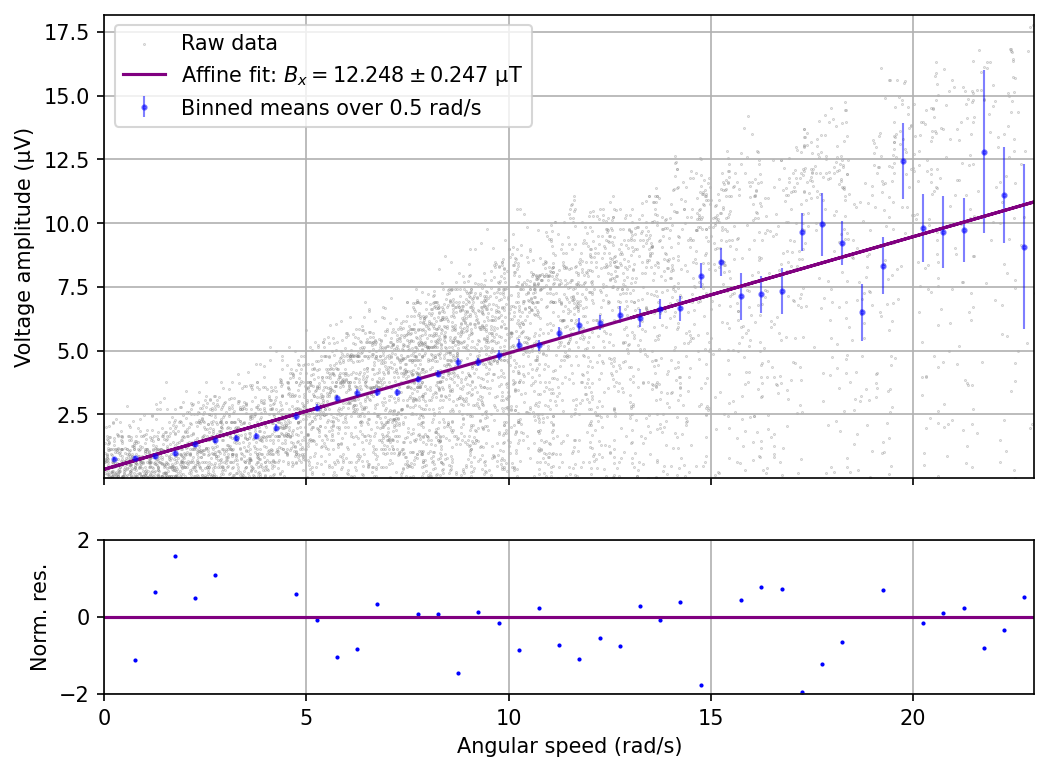

In [432]:
fig, [ax1, ax2] = plt.subplots(2,1,sharex=True,figsize=(8,6),gridspec_kw={'height_ratios': [3, 1]})

plt.sca(ax1)
plt.scatter(aw, av, s=0.1, color="gray", alpha=0.5, label="Raw data")
plt.errorbar(
    wb, vb, yerr = dvb,
    label=f"Binned means over {wb_width} rad/s",
    color = "blue", ecolor="blue",
    linewidth = 0, elinewidth = 1, capsize=0, markersize = 2, alpha=0.5,
    marker = 'o'
)
plt.plot(aw, fit(aw, B, z), color="purple", label=f"Affine fit: $B_x = {B:.3f} \pm {dB:.3f}$ µT")
plt.xlim(0,23)

plt.ylabel("Voltage amplitude (µV)")
plt.margins(0)
plt.grid()
plt.legend()

plt.sca(ax2)
plt.scatter(wb, (fit(wb, B, z) - vb)/dvb, s=1, c="blue")
plt.ylim(-2,2)
plt.axhline(0, color="purple")
plt.ylabel("Norm. res.")
plt.xlabel("Angular speed (rad/s)")
plt.grid()



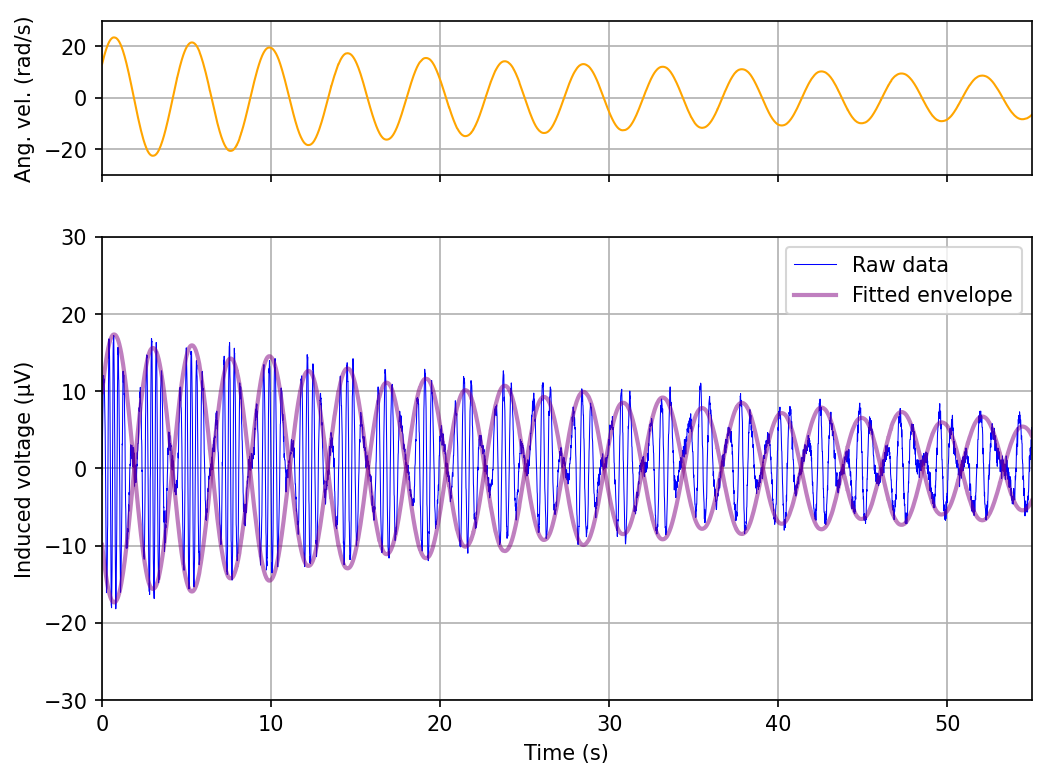

In [433]:
fig, [ax2, ax1] = plt.subplots(2,1,sharex=True,figsize=(8,6),gridspec_kw={'height_ratios': [1, 3]})

ax1.plot(t, v, lw=0.5, color="blue", label="Raw data")
ax1.set_ylabel("Induced voltage (µV)")
ax1.set_ylim(-30,30)

ax1.plot(t, fit(w,B,z)*np.pi/2, color="purple", alpha=0.5, lw=2)
ax1.plot(t, -fit(w,B,z)*np.pi/2, color="purple", alpha=0.5, lw=2, label="Fitted envelope")
ax1.legend()
ax1.grid()

ax2.plot(t, w, lw=1, color="orange")

ax2.grid()
ax2.set_ylabel("Ang. vel. (rad/s)")
ax1.set_xlabel("Time (s)")
ax2.set_ylim(-30,30)
ax2.set_xlim(0,55)

plt.margins(0)

plt.show()

In [434]:
dof = 1
chi2 = np.sum( ((fit(wb, B, z) - vb)/dvb)**2 )
chi2_reduced = chi2 / ( len(wb) - dof )
chi2_reduced

1.8463432559611013